## Import libraries

In [1]:
import sys
sys.path.append('../') 
from imports import *
# from sklearn.svm import SVC
from sklearn.utils import resample
import cudf
import cupy as cp
import cuml
from cuml.svm import SVC, LinearSVC


In [2]:
def plot_roc_pr_curves(y_true, y_probs, n_bootstraps=1000):
    """Perform bootstrapping to calculate 95% confidence intervals for ROC and PR curves and plot them"""
    bootstrap_auroc_scores = []
    bootstrap_average_precision_scores = []

    for _ in range(n_bootstraps):
        # Bootstrap sample (with replacement)
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_boot = y_true[indices]
        y_probs_boot = y_probs[indices]

        # Compute metrics for bootstrap sample
        bootstrap_auroc_scores.append(roc_auc_score(y_true_boot, y_probs_boot))
        bootstrap_average_precision_scores.append(average_precision_score(y_true_boot, y_probs_boot))

    # Compute confidence intervals
    auroc_lower = np.percentile(bootstrap_auroc_scores, 2.5)
    auroc_upper = np.percentile(bootstrap_auroc_scores, 97.5)
    ap_lower = np.percentile(bootstrap_average_precision_scores, 2.5)
    ap_upper = np.percentile(bootstrap_average_precision_scores, 97.5)

    # Calculate original ROC and PR curves
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auroc = roc_auc_score(y_true, y_probs)
    average_precision = average_precision_score(y_true, y_probs)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right", title=f'95% CI: [{auroc_lower:.2f}, {auroc_upper:.2f}]')

    # Precision-Recall Curve
    ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {average_precision:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left", title=f'95% CI: [{ap_lower:.2f}, {ap_upper:.2f}]')

    plt.show()

    # Return the confidence intervals
    return (np.round(auroc_lower,2), np.round(auroc_upper,2)), (np.round(ap_lower,2), np.round(ap_upper,2))




## Loading pre-processed saved datasets

In [3]:
# loading processed data
df_train = pd.read_csv('./uci-adult-processed-data/train.csv')
df_val = pd.read_csv('./uci-adult-processed-data/val.csv')
df_test = pd.read_csv('./uci-adult-processed-data/test.csv')

# Define your features and target variable
target_column = 'target' 
features = df_train.columns.drop(target_column)

# Separate features and target and convert to NumPy arrays
X_train = df_train[features].to_numpy()
y_train = df_train[target_column].to_numpy()
X_val = df_val[features].to_numpy()
y_val = df_val[target_column].to_numpy()
X_test = df_test[features].to_numpy()
y_test = df_test[target_column].to_numpy()

# convert to cupy arrays
X_train_cp = cp.array(X_train, dtype=cp.float32)
y_train_cp = cp.array(y_train, dtype=cp.float32)
X_val_cp = cp.array(X_val, dtype=cp.float32)
y_val_cp = cp.array(y_val, dtype=cp.float32)
X_test_cp = cp.array(X_test, dtype=cp.float32)
y_test_cp = cp.array(y_test, dtype=cp.float32)

In [4]:
# calculate the class weights
num_zeros = np.sum(y_train == 0)
num_ones = np.sum(y_train == 1)

total = y_train.size
percent_zeros = (num_zeros / total) * 100
percent_ones = (num_ones / total) * 100

print(f"Percentage of 0's: {percent_zeros:.2f}%")
print(f"Percentage of 1's: {percent_ones:.2f}%")

Percentage of 0's: 75.21%
Percentage of 1's: 24.79%


In [5]:
# Set class weights
class_weights = {0: 1, 1: 3}  # Since class 1 is approximately 3 times less frequent than class 0

# Initialize the SVM model without kernel
svm_linear = LinearSVC(loss='squared_hinge', penalty='l1', C=1, probability=True, class_weight=class_weights, output_type='numpy')

# Train the model on the training set
svm_linear.fit(X_train_cp, y_train_cp)

# Predict and evaluate
y_val_pred = svm_linear.predict(X_val)

# Extract the probabilities for the positive class
y_val_probs = svm_linear.predict_proba(X_val)[:, 1]

# confusion matrix and classification report
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

[W] [02:24:18.509448] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[[4873  229]
 [1152  529]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      5102
           1       0.70      0.31      0.43      1681

    accuracy                           0.80      6783
   macro avg       0.75      0.63      0.65      6783
weighted avg       0.78      0.80      0.77      6783

Validation Set Accuracy: 0.7964


In [6]:
# Compute AUROC
auroc = roc_auc_score(y_val, y_val_probs)
print(f"Area under the ROC curve: {auroc:.4f}")

# Compute Precision-Recall curve and its area
average_precision = average_precision_score(y_val, y_val_probs)
print(f"Area under the Precision-Recall curve: {average_precision:.4f}")

Area under the ROC curve: 0.7469
Area under the Precision-Recall curve: 0.5631


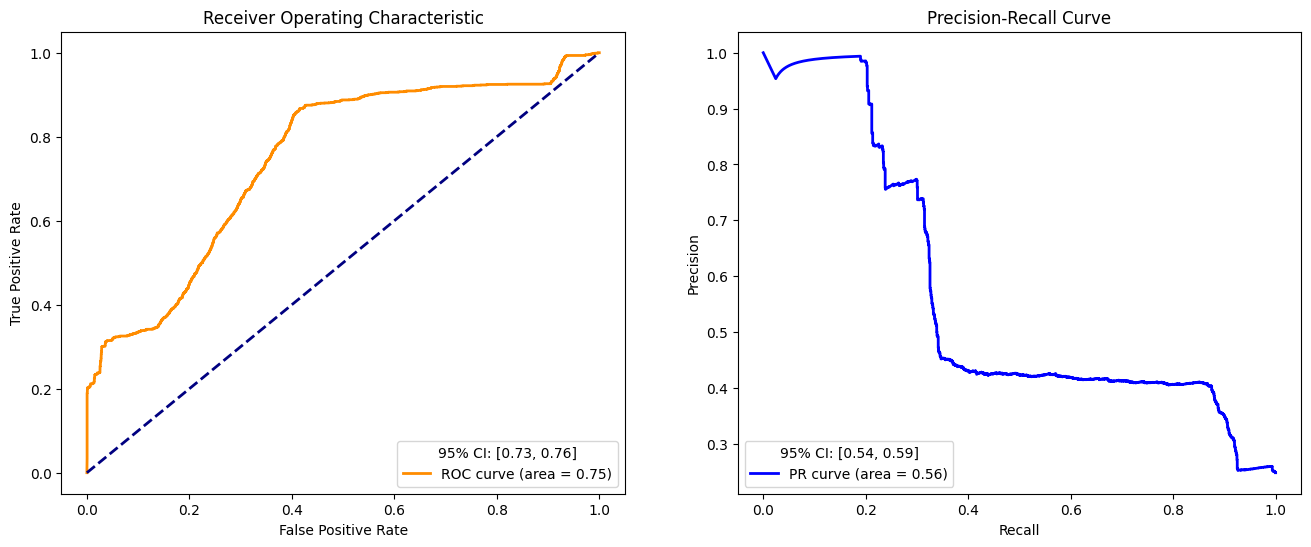

((0.73, 0.76), (0.54, 0.59))

In [7]:
# Plot ROC and PR curves for linear SVC
plot_roc_pr_curves(y_val, y_val_probs)

# SVM with Polynomial kernel 

In [8]:
# Initialize the SVM model with polynomial kernel
svm_poly = SVC(kernel='poly', probability=True, class_weight=class_weights, output_type='numpy')

# Train the model on the training set
svm_poly.fit(X_train_cp, y_train_cp)

SVC()

In [9]:
# Predict and evaluate on validation set
y_val_poly_pred = svm_poly.predict(X_val)

# Extract the probabilities for the positive class
y_val_poly_prob = svm_poly.predict_proba(X_val)[:, 1]

print(confusion_matrix(y_val, y_val_poly_pred))
print(classification_report(y_val, y_val_poly_pred))

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_poly_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

[[5099    3]
 [1620   61]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      5102
           1       0.95      0.04      0.07      1681

    accuracy                           0.76      6783
   macro avg       0.86      0.52      0.47      6783
weighted avg       0.81      0.76      0.67      6783

Validation Accuracy: 0.7607


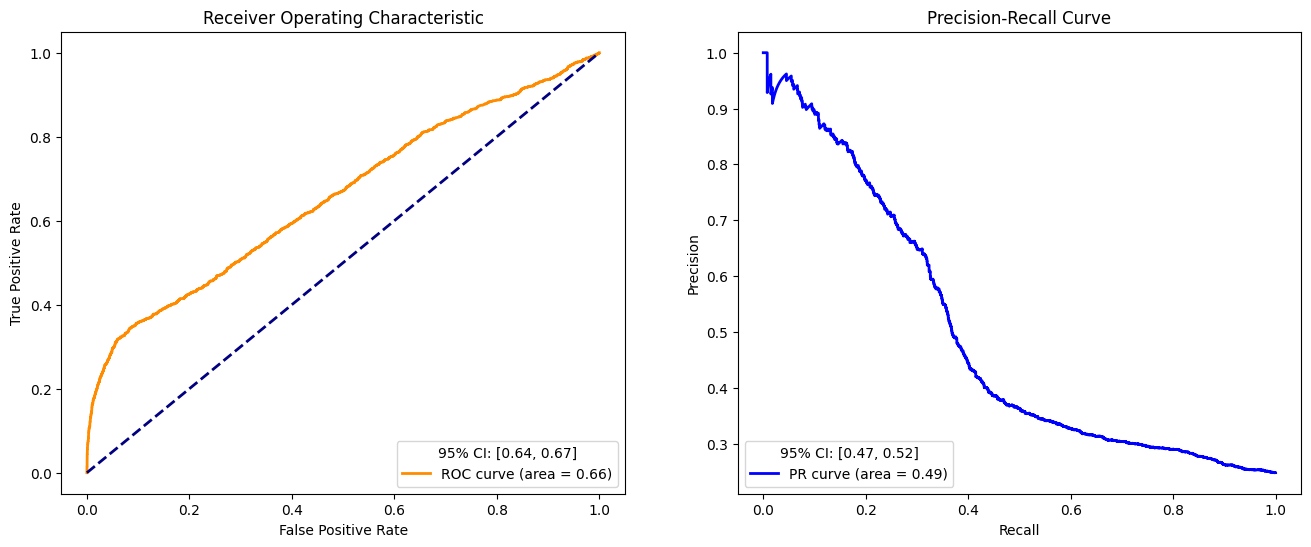

((0.64, 0.67), (0.47, 0.52))

In [10]:
# Plot ROC and PR curves for polynomial SVC with 95% confidence intervals
plot_roc_pr_curves(y_val, y_val_poly_prob)

# SVM with rbf kernel

In [11]:
# Initialize the SVM model with rbf kernel
svm_rbf = SVC(kernel='rbf', probability=True, class_weight=class_weights , output_type='numpy')

# Train the model on the training set
svm_rbf.fit(X_train_cp, y_train_cp)

SVC()

In [12]:
# Predict and evaluate
y_val_rbf_pred = svm_rbf.predict(X_val)

# Extract the probabilities for the positive class
y_val_rbf_prob = svm_rbf.predict_proba(X_val)[:, 1]

print(confusion_matrix(y_val, y_val_rbf_pred))
print(classification_report(y_val, y_val_rbf_pred))

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_rbf_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

[[5096    6]
 [1378  303]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      5102
           1       0.98      0.18      0.30      1681

    accuracy                           0.80      6783
   macro avg       0.88      0.59      0.59      6783
weighted avg       0.84      0.80      0.74      6783

Validation Accuracy: 0.7960


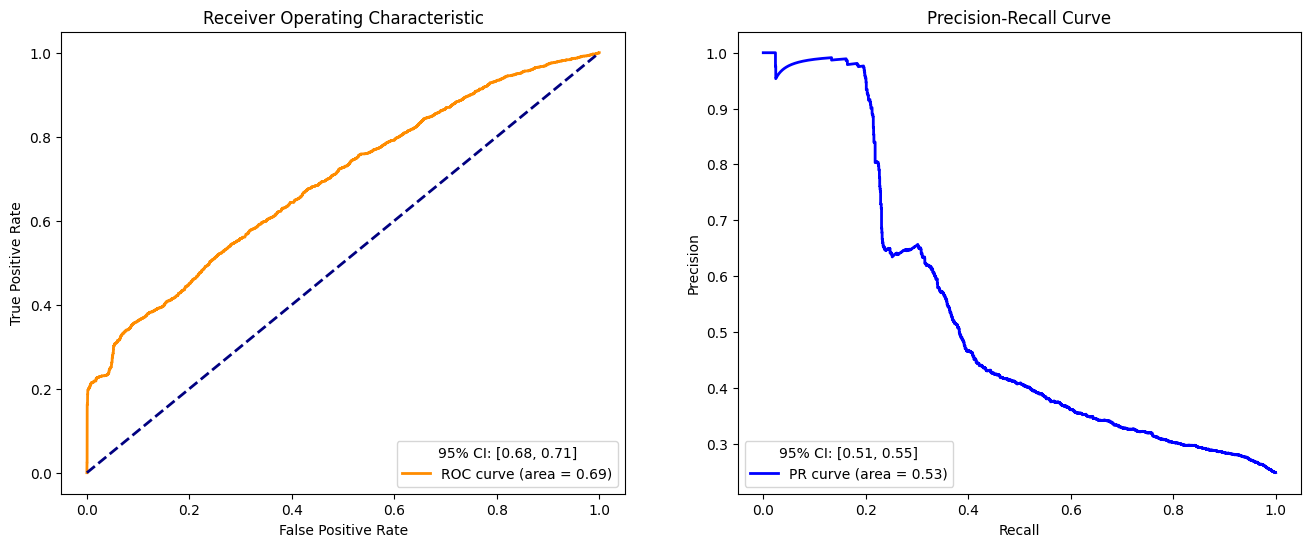

((0.68, 0.71), (0.51, 0.55))

In [13]:
# Plot ROC and PR curves for rbf SVC with 95% confidence intervals
plot_roc_pr_curves(y_val, y_val_rbf_prob)

### Even though Linear SVC is best based on AUROC and area under PR curves but we are choosing SVC with RBF kernel as the best model since better predictions according to confusion matrix

## SVC with RBF kernel on test set

In [14]:
# Predict on the test set
y_test_pred = svm_rbf.predict(X_test)

# Predict probabilities on the test set
y_test_probs = svm_rbf.predict_proba(X_test)[:, 1]

# Compute AUROC
auroc = roc_auc_score(y_test, y_test_probs)
print(f"Area under the ROC curve: {auroc:.2f}")

# Compute Precision-Recall curve and its area
average_precision = average_precision_score(y_test, y_test_probs)
print(f"Area under the Precision-Recall curve: {average_precision:.2f}")

Area under the ROC curve: 0.68
Area under the Precision-Recall curve: 0.51


Test Accuracy: 0.7895
[[5095    8]
 [1420  261]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5103
           1       0.97      0.16      0.27      1681

    accuracy                           0.79      6784
   macro avg       0.88      0.58      0.57      6784
weighted avg       0.83      0.79      0.73      6784



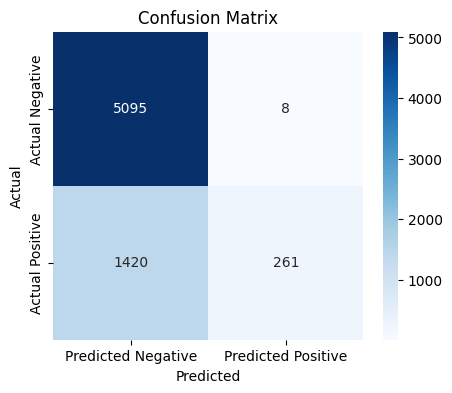

In [15]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(cm)
print(classification_report(y_test, y_test_pred))


# Plotting the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

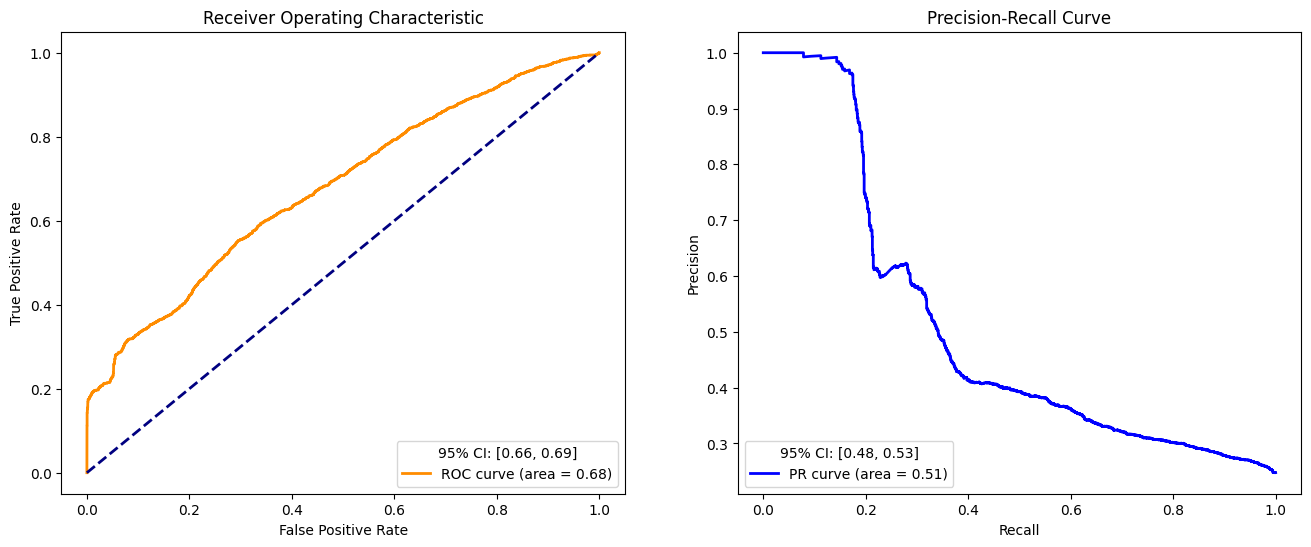

((0.66, 0.69), (0.48, 0.53))

In [16]:
# Plot AUROC and PR curves on test set with 95% confidence intervals
plot_roc_pr_curves(y_test, y_test_probs)

### Doing predictions on test set with Linear SVC also for comparison

In [17]:
# Predict on the test set
y_test_pred_1 = svm_linear.predict(X_test)

# Predict probabilities on the test set
y_test_probs_1 = svm_linear.predict_proba(X_test)[:, 1]

# Compute AUROC
auroc = roc_auc_score(y_test, y_test_probs_1)
print(f"Area under the ROC curve: {auroc:.2f}")

# Compute Precision-Recall curve and its area
average_precision = average_precision_score(y_test, y_test_probs_1)
print(f"Area under the Precision-Recall curve: {average_precision:.2f}")

Area under the ROC curve: 0.74
Area under the Precision-Recall curve: 0.54


Test Accuracy: 0.7866
[[4836  267]
 [1181  500]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      5103
           1       0.65      0.30      0.41      1681

    accuracy                           0.79      6784
   macro avg       0.73      0.62      0.64      6784
weighted avg       0.77      0.79      0.76      6784



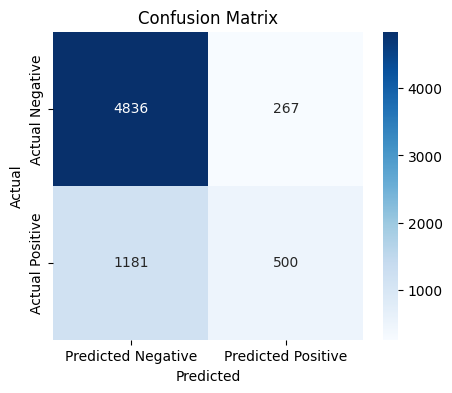

In [18]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_1)
test_accuracy = accuracy_score(y_test, y_test_pred_1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(cm)
print(classification_report(y_test, y_test_pred_1))


# Plotting the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

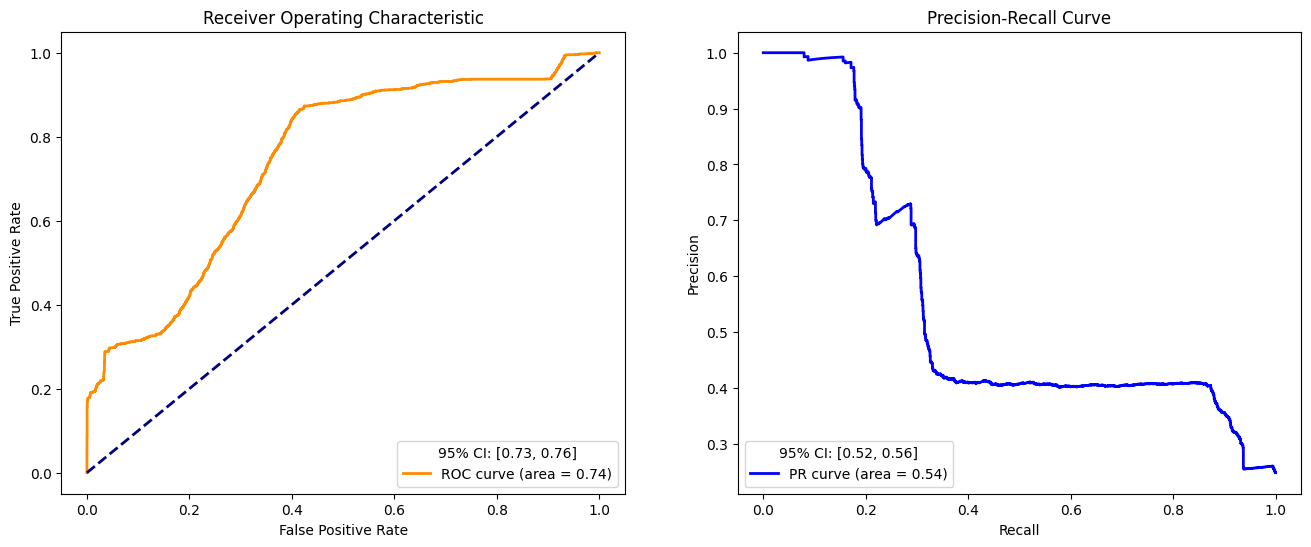

((0.73, 0.76), (0.52, 0.56))

In [19]:
# Plot AUROC and PR curves on test set with 95% confidence intervals
plot_roc_pr_curves(y_test, y_test_probs_1)

## since linear SVC handles class imbalance the best (more correct predictions for positive class), Linear SVC is our final model